In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load data
X = pd.read_csv('data/fingerprints.csv', index_col = 0)
df = pd.read_csv('data/p2x4_final.csv', index_col = 0)
Y = df['pIC50']
# Feature Selection
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [3]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=6)

In [4]:
# Hyperparameter grid for ExtraTreesRegressor
param_grid_etr = {
    'n_estimators': [10, 50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
    
}

In [5]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 4


In [6]:
# GridSearchCV for ExtraTreesRegressor
grid_search_etr = GridSearchCV(estimator=ExtraTreesRegressor(random_state=6),
                              param_grid=param_grid_etr, cv=5, n_jobs=N_CORES, verbose=2)
grid_search_etr.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=6), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 150]},
             verbose=2)

In [7]:
# Selecting the best estimator from each GridSearchCV
best_model_etr = grid_search_etr.best_estimator_

# Step 1: Predict on Test Set

In [8]:
y_pred = best_model_etr.predict(X_test)

# Step 2: Calculate Performance Metrics

Since this is a regression problem, you can use metrics such as Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and R-squared

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)


MSE: 0.2821761863482915
RMSE: 0.5312025850354001
MAE: 0.2960276118444635
R2: 0.8409090868700415


# Step 3: Analyze Residuals

Analyzing the residuals (difference between the predicted and actual values) can provide insights into the behavior of your model

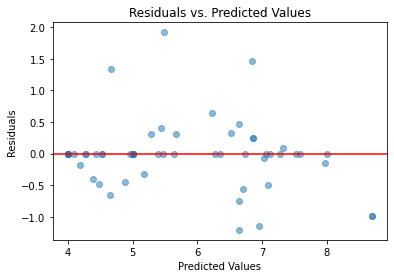

In [10]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Step 4: Compare with Baseline 

It can be helpful to compare your model's performance against a simple baseline model, such as predicting the mean of the target variable for all instances. This gives you a reference point for how much your model has learned.

In [11]:
# Baseline predictions (mean of target variable)
baseline_preds = np.full_like(y_test, np.mean(y_train))

# Baseline Mean Squared Error
baseline_mse = mean_squared_error(y_test, baseline_preds)

print(f"Baseline Mean Squared Error: {baseline_mse}")
print(f"Model Mean Squared Error: {mse}")

Baseline Mean Squared Error: 1.795130876257679
Model Mean Squared Error: 0.2821761863482915


In [12]:
print(f"Best ExtraTreesRegressor: {grid_search_etr.best_params_}")

Best ExtraTreesRegressor: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# Maybridge

In [13]:
maybridge_data = pd.read_csv("maybridge/Maybridge.csv")
maybridge_data

,SMILES,Code
0,Fc1ccc(C(c2ccc(F)cc2)N2CCNCC2)cc1,AC10018
1,CSc1nc(N)nc2nc[nH]c12,AC12157
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917
3,O=C(O)c1ccc(Br)o1,AC27191
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806
...,...,...
51768,CCO/C(C)=N/Oc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],S14814
51769,O=C1c2ccccc2C(=O)N1Oc1ccc([N+](=O)[O-])c([N+](...,S14839
51770,O=[N+]([O-])c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1,S14896
51771,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1/C=C/c1ccccc1,SPB05721


In [14]:
descriptors = pd.read_csv('maybridge/out.csv', index_col = 0)
descriptors.shape

(51773, 881)

In [15]:
descriptors = selection.transform(descriptors)
descriptors.shape

(51773, 155)

In [16]:
# Apply the imputer to fill NaN values with the mean of each column
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
descriptors_imputed = imputer.fit_transform(descriptors)

In [17]:
# Step 3: Make Predictions
predicted_pic50 = best_model_etr.predict(descriptors_imputed)

In [18]:
# Step 4: Analyze Results
# Append predictions to the Maybridge data
maybridge_data["predicted_pic50"] = predicted_pic50

In [19]:
maybridge_data

,SMILES,Code,predicted_pic50
0,Fc1ccc(C(c2ccc(F)cc2)N2CCNCC2)cc1,AC10018,4.867591
1,CSc1nc(N)nc2nc[nH]c12,AC12157,4.991466
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917,5.256599
3,O=C(O)c1ccc(Br)o1,AC27191,5.072727
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806,5.653042
...,...,...,...
51768,CCO/C(C)=N/Oc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],S14814,5.031755
51769,O=C1c2ccccc2C(=O)N1Oc1ccc([N+](=O)[O-])c([N+](...,S14839,5.440425
51770,O=[N+]([O-])c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1,S14896,5.352169
51771,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1/C=C/c1ccccc1,SPB05721,5.020930


In [20]:
# Identify potent inhibitors
threshold = 6 # Define a threshold for pic50 values 
potent_inhibitors = maybridge_data[maybridge_data["predicted_pic50"] >= threshold]

In [21]:
potent_inhibitors

,SMILES,Code,predicted_pic50
66,O=C(Nc1ccc(-n2nccc2C(F)(F)F)cc1)c1ccc(Cl)cc1,AW00193,6.198511
108,O=S(=O)(Nc1ccc(Oc2ccc(OC(F)(F)F)cc2)cc1)c1cc(C...,EN00044,6.222803
109,O=S(=O)(Nc1ccc(Oc2ccc(OC(F)(F)F)cc2)cc1)c1cccc...,EN00072,6.222803
110,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,EN00095,6.520359
250,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,AW00256,6.520359
...,...,...,...
51460,O=C(Nc1cccnc1Cl)c1ccccc1,S14430,6.129581
51461,O=C(Nc1cccnc1Cl)c1cccnc1Cl,S14447,6.036815
51468,CS(=O)(=O)c1ccc(C(=O)Nc2ccccc2Cl)cc1,S14384,6.165817
51469,CS(=O)(=O)c1ccc(C(=O)Nc2cccc(Cl)c2)cc1,S14416,6.165817


In [22]:
# Sort the potent_inhibitors DataFrame based on "predicted_pic50" in descending order
sorted_potent_inhibitors = potent_inhibitors.sort_values(by="predicted_pic50", ascending=False)
sorted_potent_inhibitors

,SMILES,Code,predicted_pic50
31216,O=C(COc1ccc(S(=O)(=O)Nc2ccccc2)cc1Cl)c1ccccc1,NH00210,7.227183
1965,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)Nc1cccc(C#N)c1,CD00823,6.912466
9078,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)Nc1cc(C(F)(F)F)cc...,HTS01341,6.912466
9656,C#Cc1cccc(NC(=O)c2c(-c3c(Cl)cccc3Cl)noc2C)c1,BTB05364,6.912466
12011,C/C(=N\O)c1ccc(Cl)c(NC(=O)c2c(-c3ccccc3Cl)noc2...,BTB07062,6.909965
...,...,...,...
4438,COc1c(Cl)cc(Cl)c(OC)c1C(=O)NC(=O)Nc1cc(C(F)(F)...,CD02346,6.000530
15556,Cc1noc(C)c1C(=O)NNc1cc(Cl)ccc1Cl,SPB02841,6.000424
48311,CC(C)c1ccc(NC(=O)CSc2ncc(-c3ccc(Cl)cc3)n2C)cc1,RJC02218,6.000410
22068,Cc1cc(C)c2c3c(sc2n1)C(=O)N(c1ccc(Cl)cc1)CC(=O)N3,DP00704,6.000263


In [23]:
sorted_potent_inhibitors.predicted_pic50.describe()

count    1622.000000
mean        6.184726
std         0.172677
min         6.000263
25%         6.056078
50%         6.131697
75%         6.258610
max         7.227183
Name: predicted_pic50, dtype: float64

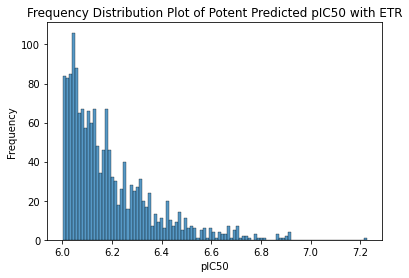

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=potent_inhibitors, x='predicted_pic50', kde=False, bins=100)

# Set the title and labels for the plot
plt.title('Frequency Distribution Plot of Potent Predicted pIC50 with ETR')
plt.xlabel('pIC50')
plt.ylabel('Frequency')


plt.savefig('figures/potent_predicted_etr.png')
# Show the plot
plt.show()

In [25]:
# Save the potent inhibitors to a CSV file
potent_inhibitors.to_csv("maybridge/etr_potent_p2x4_inhibitors.csv", index=False)

In [26]:
# 1. Load the common potent inhibitors
common_df = pd.read_csv("maybridge/common_potent_inhibitors.csv")
common_df

,smiles
0,O=C(Nc1ccccc1Cl)c1ccc(-c2ccccn2)s1
1,O=C(Nc1ccccc1Sc1nc2ccc(Cl)cc2s1)c1ccc(F)cc1
2,COC(=O)c1cccc(NC(=O)c2ccc(Cl)cc2)c1
3,N#Cc1ccc(-c2c(NC(=O)NS(=O)(=O)c3ccccc3Cl)oc(-c...
4,Cc1onc(-c2ccccc2)c1C(=O)Nc1ccc(C(F)(F)F)cc1Cl
...,...
383,Cc1cc(NS(=O)(=O)c2ccc(NC(=O)c3ccccc3Cl)cc2)no1
384,O=C(Nc1cccc(-c2nc3ccccc3[nH]2)c1)c1ccc(F)cc1
385,O=C(Nc1ccc(NC(=S)Nc2ccc(Cl)cc2)cc1)c1ccccc1O
386,Cc1c(CC(=O)Nc2ccc(Cl)cc2)sc2ccc(Cl)cc12


In [27]:
filtered_potent_inhibitors = potent_inhibitors[potent_inhibitors["SMILES"].isin(common_df["smiles"])]
filtered_potent_inhibitors

,SMILES,Code,predicted_pic50
66,O=C(Nc1ccc(-n2nccc2C(F)(F)F)cc1)c1ccc(Cl)cc1,AW00193,6.198511
110,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,EN00095,6.520359
250,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,AW00256,6.520359
650,CC(=O)Nc1cccc(OCCCNS(=O)(=O)c2ccc(N3C(=O)CC4(C...,AW00490,6.483043
758,O=C(NCCNS(=O)(=O)c1ccc(Cl)cc1)C1=Cc2cc(Cl)ccc2OC1,GK00081,6.476321
...,...,...,...
49720,Cc1onc(-c2ccc(Cl)cc2)c1-c1ccnc(SCC(=O)Nc2ccc(C...,S10227,6.490555
49780,Cc1cc(-c2nc(C)c(-c3nnc(SCC(=O)Nc4ccc(C(C)C)cc4...,S15050,6.084289
50705,CCOC(=O)c1cc2c(NC(=O)c3ccc(Cl)cc3)c(C(=O)OCC)s...,RJF02129,6.078559
51287,O=C(Cc1ccccc1)Nc1ccc(Cl)cc1,S13395,6.219604


In [28]:
filtered_potent_inhibitors.predicted_pic50.describe()

count    394.000000
mean       6.266869
std        0.194593
min        6.010511
25%        6.105971
50%        6.217749
75%        6.410522
max        6.909965
Name: predicted_pic50, dtype: float64

In [30]:
# 3. Sort the filtered data based on pic50 values in descending order (assuming higher is more potent)
sorted_common = filtered_potent_inhibitors.sort_values(by="predicted_pic50", ascending=False)
sorted_common

,SMILES,Code,predicted_pic50
12011,C/C(=N\O)c1ccc(Cl)c(NC(=O)c2c(-c3ccccc3Cl)noc2...,BTB07062,6.909965
9460,O=C(Nc1ccc(F)cc1F)c1cc(Cl)cc(Cl)c1O,SPB00540,6.884341
33798,Nc1cc(NC(=O)c2ccccc2O)ccc1Cl,XBX00319,6.875269
40069,CC(C)c1ccc(NC(=S)NC(=O)c2ccccc2)cc1,S01527,6.865384
47836,CC(C)c1ccc(NC(=S)NC(=O)c2ccc(C(F)(F)F)cc2)cc1,RJC01761,6.865384
...,...,...,...
33709,O=C(Nc1ccc(NC(=S)Nc2ccc(Cl)cc2)cc1)c1ccccc1O,HTS07551,6.017209
13131,NC(=O)c1sc(-c2ccc(Cl)cc2)cc1NC(=O)/C=C\C(=O)O,KM03526,6.015242
14465,Cc1ccc(C(=O)Nc2cccc(-c3nc4ccccc4[nH]3)c2)cc1,SPB02327,6.013184
8046,Cc1c(C)c(C)c(C(=O)c2ccc(NC(=O)c3sc4ccccc4c3Cl)...,BTB04464,6.010765


In [36]:
# Save the potent inhibitors to a CSV file
sorted_common.to_csv("maybridge/etr_sorted_common.csv", index=False)

In [31]:
best_model_etr

ExtraTreesRegressor(max_features='log2', random_state=6)

In [34]:
top20 = sorted_common.sort_values(by="predicted_pic50", ascending=False).head(20)
top20

,SMILES,Code,predicted_pic50
12011,C/C(=N\O)c1ccc(Cl)c(NC(=O)c2c(-c3ccccc3Cl)noc2...,BTB07062,6.909965
9460,O=C(Nc1ccc(F)cc1F)c1cc(Cl)cc(Cl)c1O,SPB00540,6.884341
33798,Nc1cc(NC(=O)c2ccccc2O)ccc1Cl,XBX00319,6.875269
40069,CC(C)c1ccc(NC(=S)NC(=O)c2ccccc2)cc1,S01527,6.865384
47836,CC(C)c1ccc(NC(=S)NC(=O)c2ccc(C(F)(F)F)cc2)cc1,RJC01761,6.865384
41399,CC(C)(C)c1ccc(NC(=S)NC(=O)c2ccc([N+](=O)[O-])c...,SEW04372,6.865384
40777,CCCN(CCC)S(=O)(=O)c1ccc(C(=O)Nc2ccc(Oc3ccc(Cl)...,HTS12671,6.810779
16267,O=C(NCc1ccc(S(=O)(=O)Nc2ccc3c(c2)OCCO3)s1)c1cc...,BTB08982,6.799117
22204,NS(=O)(=O)c1ccc(NC(=O)CSc2nnc(-c3ccc(Cl)cc3)o2...,HTS04304,6.747435
3245,O=c1c2cc(NS(=O)(=O)c3ccc(Cl)cc3)ccc2oc2ncccc12,BTB00089,6.745092


In [35]:
top20.to_csv("maybridge/etr_top20.csv", index=False)